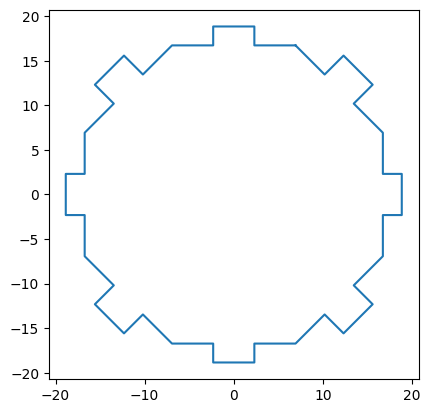

In [1]:
import parse_data.preprocess as preprocess
import parse_data.loading as loading
from analysis.response_times import calculate_response_times, plot_response_times
import globals
from plotting import plot_octagon, plot_trajectory
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
import math

In [2]:
# paths
data_folder = '/home/tom/Documents/SWC/data' # desktop Duan Lab
# json_filename = '240913_Yansu_Jerry/2024-09-13_11-53-34_YansuSecondSolo.json' 
json_filename = '240913_Yansu_Jerry/2024-09-13_11-31-00_YansuJerrySocial.json'
# data_folder = r'D:\Users\Tom\OneDrive\PhD\SWC\data' # desktop home
# json_filename = r'first_experiments_2409\240913\2024-09-13_11-23-37_YansuFirstSolo.json'


In [3]:
# Load JSON file into pandas df with collapsed data dictionary and adjustments based on date of recording 
df = loading.loading_pipeline(data_folder, json_filename)

Data is from period before 2024-09-13 11:31:00
Running dataframe through playerinfo_playerposition_conversion.
Loading complete.


In [4]:
# Pre-process data 
df = preprocess.standard_preprocessing(df)

Preprocessing complete.


In [5]:
## Extract single trials ##

In [6]:
def split_session_by_trial(df):
    
    # groupby produces an interable of tuples with the group key and the dataframe 
    trials_list = [data for _, data in df.groupby('data.trialNum')]
    
    # exclude trial 0 (could also exclude trial 1)
    trials_list = trials_list[1:]

    # if final  trial does not contain a server selected trigger activation, discard it
    if not globals.SELECTED_TRIGGER_ACTIVATION in trials_list[-1]['eventDescription'].unique():
        trials_list = trials_list[:-1]

    return trials_list


In [7]:
trials_list = split_session_by_trial(df)

In [8]:
## rotate trials ##

In [9]:
def find_rotation_angle_trial(trial):
    """ Find CCW angle of rotation for vector to 
    rotate arena s.t. high wall is at wall 1"""

    
    
    # identify trial walls
    wall1 = trial.iloc[0]['data.wall1']
    wall2 = trial.iloc[0]['data.wall2']
    
    # find difference of high wall to wall 1
    difference = wall1 - 1
        
    # find CCW rotation angle 
    unitary_rotation_ang = 2*math.pi/globals.NUM_WALLS
    theta = unitary_rotation_ang * difference

    return theta

In [10]:
def rotation(trial, theta):
    """ Take counterclockwise rotation angle and starting vector
        Return rotated vector """

    rotated_coordinates = []

    num_players = preprocess.num_players(df)
    
    trial_copy = trial.copy()

    # create rotation matrix
    rotM = np.array([
                    [math.cos(theta), -math.sin(theta)],
                     [math.sin(theta), math.cos(theta)]
                    ])

    for i in range(num_players):
        x,y = trial_copy[globals.PLAYER_LOC_DICT[i]['xloc']], trial_copy[globals.PLAYER_LOC_DICT[i]['yloc']]

        this_coordinates = np.vstack([x,y])
        this_rotated_coordinates = np.matmul(rotM, this_coordinates) 

        rotated_coordinates.append(this_rotated_coordinates)

    return rotated_coordinates
    
        
    

    
        
    

In [11]:
trial = trials_list[0]

In [12]:
theta = find_rotation_angle_trial(trial)

In [13]:
rotated_coords = rotation(trial, theta)

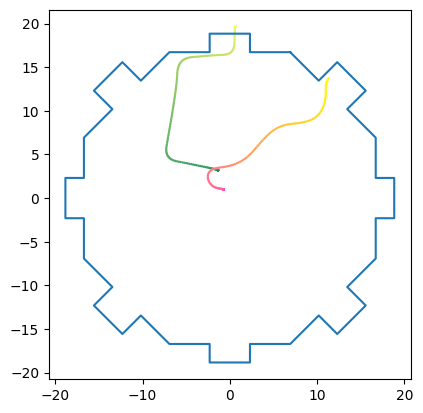

{'data.playerPosition.0.location.x': array([-1.35949934, -1.35949934, -1.35949934, -1.35949934, -1.35949934,
        -1.35949934, -1.35949934, -1.35949934, -1.35949934, -1.35949934,
        -1.35949934, -1.35949934, -1.35949934, -1.35949934, -1.35949934,
        -1.35949934, -1.35949934, -1.35949934, -1.35949934, -1.35949934,
        -1.35949934, -1.35949934, -1.35949934, -1.35949934, -1.36356366,
        -1.37994409, -1.40878487, -1.45020664, -1.5041436 , -1.57072306,
        -1.65002513, -1.67927969, -1.75836301, -1.86539364, -1.98538351,
        -2.11960196, -2.26572561, -2.42490387, -2.59704399, -2.78207493,
        -2.97989249, -3.18427563, -3.38820314, -3.59234619, -3.79657364,
        -4.00079012, -4.20492077, -4.40906477, -4.61324596, -4.81742954,
        -5.02163744, -5.22585344, -5.43015909, -5.63506126, -5.8398695 ,
        -6.04061413, -6.22873545, -6.3999815 , -6.55652428, -6.69748449,
        -6.82396984, -6.93523645, -7.03106403, -7.11201048, -7.17771196,
        -7.2283

In [14]:
plot_trajectory.plot_trajectory(trials_list, trial_index=0, social=True)